In [1]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os

import utils
import pandas as pd

import tqdm
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.datasets import load_diabetes, load_breast_cancer, load_wine
from sklearn.preprocessing import StandardScaler

In [94]:
def load_breast_cancer_dataset(device='cuda'):
    data = load_breast_cancer()
    X_np, y_np = data['data'], data['target']
    scaler = StandardScaler()
    X_np = scaler.fit_transform(X_np)
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)
    
    # compute regression parameters
    reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=False).fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")

    return X_tensor, y_tensor, X_np, y_np

def load_wine_dataset(device='cuda'):
    data = load_wine()
    X_np, y_np = data['data'], data['target']
    scaler = StandardScaler()
    X_np = X_np[y_np!=2]
    y_np = y_np[y_np!=2]
    X_np -= X_np.mean(0)
    # X_np = scaler.fit_transform(X_np)
    X_tensor = torch.from_numpy(X_np).float().to(device)
    y_tensor = torch.from_numpy(y_np).float().to(device)
    
    # compute regression parameters
    reg = LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=False).fit(X_np, y_np)
    r2_score = reg.score(X_np, y_np)
    print(f"R^2 score: {r2_score:.4f}")

    return X_tensor, y_tensor, X_np, y_np

In [95]:
def set_random_seeds (seed=1234):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
dir_name = "./plots/"
if not os.path.exists(dir_name):
    os.makedirs(dir_name)
    
# X_tensor, y_tensor, X_np, y_np = load_breast_cancer_dataset()
X_tensor, y_tensor, X_np, y_np = load_wine_dataset()

R^2 score: 0.9923


100%|██████████| 50/50 [00:00<00:00, 1572.17it/s]


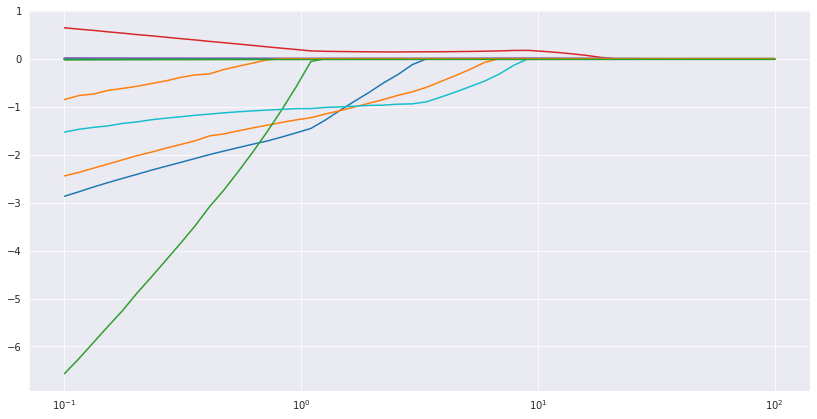

In [96]:
coefs = np.logspace(-1,2,50)
betas = [LogisticRegression(penalty='l1', solver='liblinear', fit_intercept=False, C=1/c).fit(X_np, y_np).coef_ for c in tqdm.tqdm(coefs)]
betas = np.array(betas).squeeze()
plt.figure(figsize=(14,7))
plt.plot(coefs, betas)
plt.xscale('log')
plt.show()

In [97]:
device = 'cuda'
set_random_seeds(1234)
# build model
flow_dim = X_tensor.shape[1]
q = 1
# flow = build_flow_manifold(flow_dim, norm=norm, q=q, n_layers=3, hidden_features=64, device=device)

### Train conditional flow with Laplace prior

In [126]:
q=1
params_flow = dict(q=q,
                  sigma=torch.tensor(.2),
                  lr=1e-4,#,1e-4,
                  epochs=1000,
                  T0=5,
                  Tn=1,
                  iter_per_cool_step=50,
                  lambda_min_exp=-1,#-1,
                  lambda_max_exp=2,#3,
                  sample_size=1,
                  context_size=1000,
                  device=device)
flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)

In [8]:
flow.load_state_dict(torch.load("./models/flow_T_1"))

In [127]:
flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow, loss, loss_T = utils.train_cond_model(flow, X=X_tensor, y=y_tensor, act='tanh', **params_flow)
# torch.save(flow.state_dict(), "./models/flow_T_1")
flow.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
# plt.plot(range(len(loss)), loss_T, label='loss_T')
# plt.yscale("log")
plt.legend()
plt.show()
samples_sorted, lambda_sorted, kl_sorted = utils.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                     lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=100, n_iter=1000, device='cuda')
bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], gt='logistic_regression', a=0.95, folder_name=dir_name, n_plots=1)

IndexError: list index out of range

100%|██████████| 50/50 [00:00<00:00, 1394.84it/s]


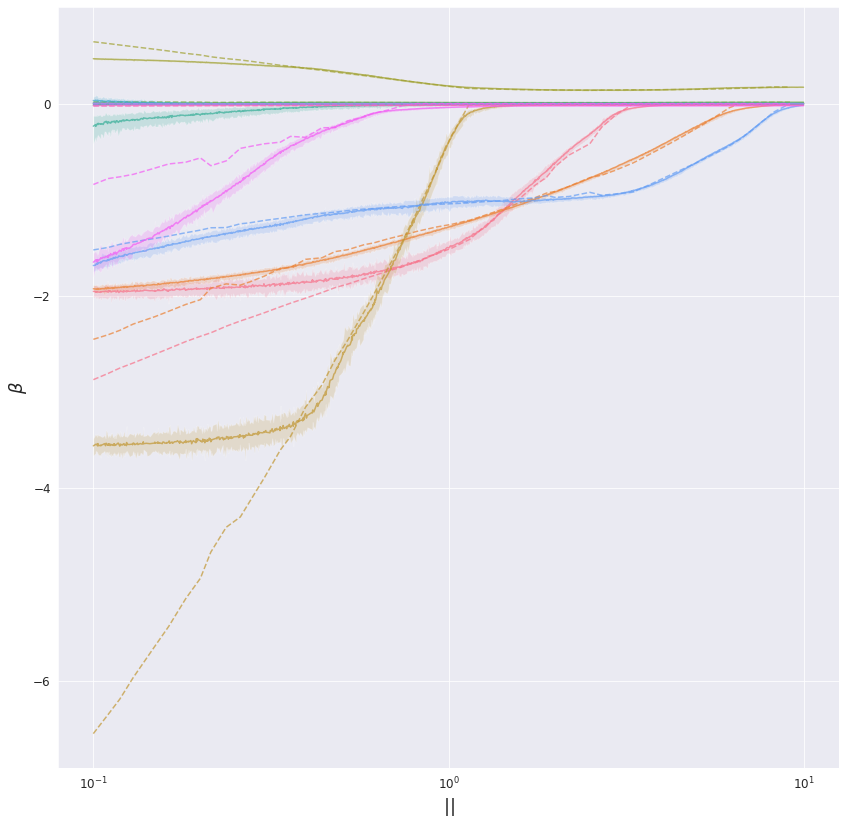

0.23472129 12.438209
min:  940


In [116]:
# samples_sorted, lambda_sorted, kl_sorted = utils.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
#                                                      lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=1000, n_iter=1000, device='cuda')
bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], 
                                                                                  gt="logistic_regression",norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=1)

Training loss at step 0: 15259.4 and 3037.9 * (T = 5.000)
Training loss at step 1: 12028.2 and 2391.7 * (T = 5.000)
Training loss at step 2: 8868.0 and 1759.7 * (T = 5.000)
Training loss at step 3: 7334.5 and 1453.1 * (T = 5.000)
Training loss at step 4: 4386.1 and 863.5 * (T = 5.000)
Training loss at step 5: 3617.1 and 709.7 * (T = 5.000)
Training loss at step 6: 2684.8 and 523.5 * (T = 5.000)
Training loss at step 7: 2221.4 and 431.1 * (T = 5.000)
Training loss at step 8: 1579.3 and 302.8 * (T = 5.000)
Training loss at step 9: 1405.0 and 268.1 * (T = 5.000)
Training loss at step 10: 918.1 and 171.0 * (T = 5.000)
Training loss at step 11: 765.1 and 140.5 * (T = 5.000)
Training loss at step 12: 691.4 and 125.9 * (T = 5.000)
Training loss at step 13: 800.0 and 147.9 * (T = 5.000)
Training loss at step 14: 655.9 and 119.2 * (T = 5.000)
Training loss at step 15: 703.2 and 129.0 * (T = 5.000)
Training loss at step 16: 621.5 and 112.7 * (T = 5.000)
Training loss at step 17: 594.6 and 107.5 

100%|██████████| 50/50 [00:00<00:00, 946.61it/s]


0.04411086 43.589283
min:  6629


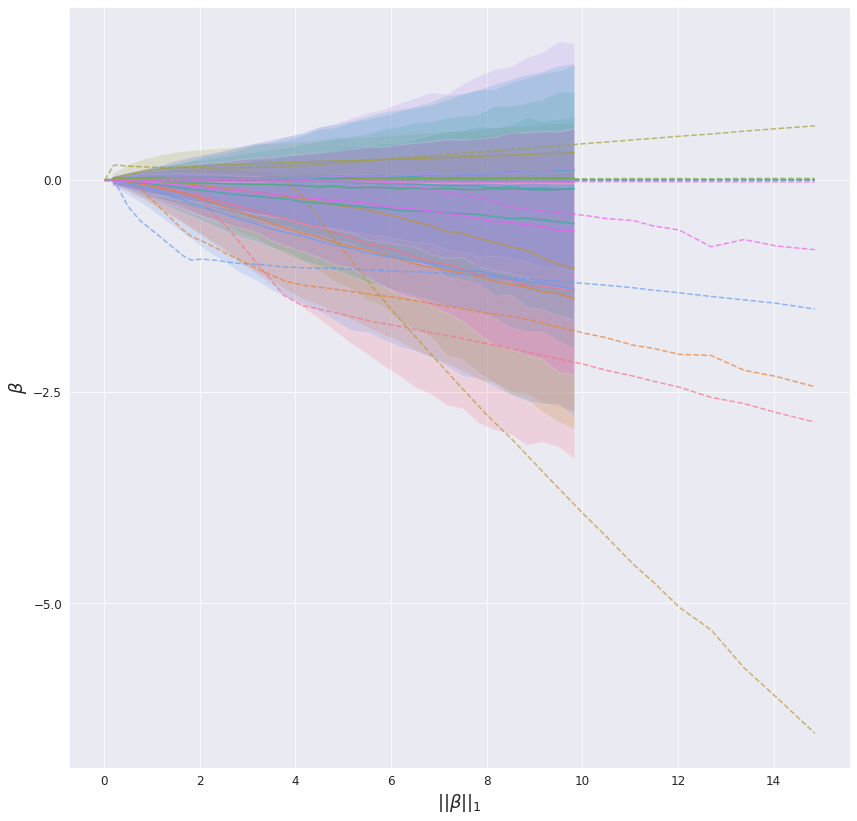

Training loss at step 0: 16562.2 and 3298.5 * (T = 5.000)
Training loss at step 1: 14413.6 and 2868.9 * (T = 5.000)
Training loss at step 2: 12327.2 and 2451.6 * (T = 5.000)
Training loss at step 3: 10284.5 and 2043.1 * (T = 5.000)
Training loss at step 4: 7247.8 and 1435.9 * (T = 5.000)
Training loss at step 5: 5336.2 and 1053.8 * (T = 5.000)
Training loss at step 6: 4082.1 and 803.1 * (T = 5.000)
Training loss at step 7: 3411.8 and 669.2 * (T = 5.000)
Training loss at step 8: 1970.4 and 381.1 * (T = 5.000)
Training loss at step 9: 1425.0 and 272.2 * (T = 5.000)
Training loss at step 10: 1101.0 and 207.6 * (T = 5.000)
Training loss at step 11: 978.7 and 183.3 * (T = 5.000)
Training loss at step 12: 797.1 and 147.2 * (T = 5.000)
Training loss at step 13: 680.5 and 124.1 * (T = 5.000)
Training loss at step 14: 710.1 and 130.3 * (T = 5.000)
Training loss at step 15: 683.6 and 125.2 * (T = 5.000)
Training loss at step 16: 686.4 and 126.0 * (T = 5.000)
Training loss at step 17: 663.8 and 1

100%|██████████| 50/50 [00:00<00:00, 1530.48it/s]


0.05054745 41.489784
min:  7068


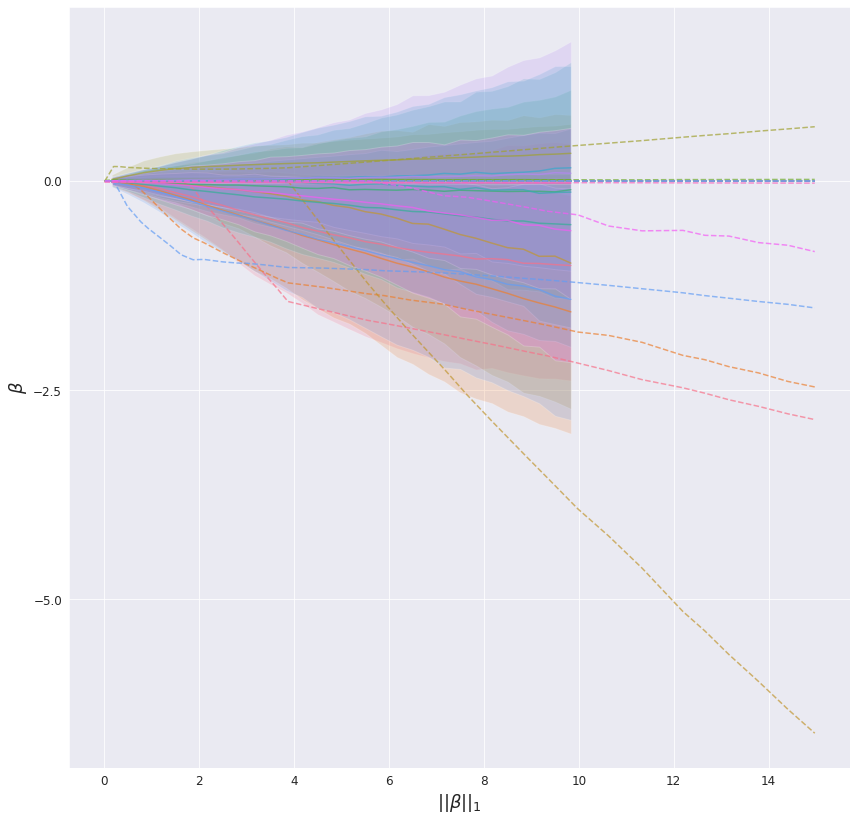

Training loss at step 0: 15075.2 and 3001.1 * (T = 5.000)
Training loss at step 1: 10809.1 and 2148.0 * (T = 5.000)
Training loss at step 2: 8969.5 and 1780.2 * (T = 5.000)
Training loss at step 3: 6987.9 and 1383.8 * (T = 5.000)
Training loss at step 4: 5163.3 and 1019.0 * (T = 5.000)
Training loss at step 5: 3865.6 and 759.6 * (T = 5.000)
Training loss at step 6: 2587.8 and 504.3 * (T = 5.000)
Training loss at step 7: 2287.2 and 444.4 * (T = 5.000)
Training loss at step 8: 1720.0 and 331.1 * (T = 5.000)
Training loss at step 9: 1356.6 and 258.7 * (T = 5.000)
Training loss at step 10: 1092.4 and 206.2 * (T = 5.000)
Training loss at step 11: 854.0 and 158.6 * (T = 5.000)
Training loss at step 12: 794.6 and 147.0 * (T = 5.000)
Training loss at step 13: 769.1 and 142.2 * (T = 5.000)
Training loss at step 14: 752.3 and 139.1 * (T = 5.000)
Training loss at step 15: 614.5 and 111.8 * (T = 5.000)
Training loss at step 16: 597.4 and 108.6 * (T = 5.000)
Training loss at step 17: 617.6 and 112.

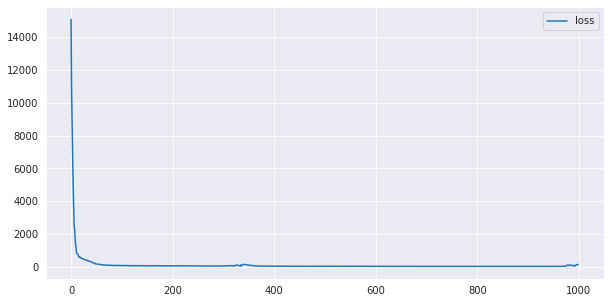

100%|██████████| 50/50 [00:00<00:00, 1091.47it/s]


0.5348203 41.957256
min:  0


/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils.py:440: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([all_samples[digitized == i][:min_n_per_bin].mean(0) for i in range(1, len(bins))])
/home/negri0001/.local/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


IndexError: cannot do a non-empty take from an empty axes.

In [125]:
# monotone_activations = ["identity", "sigmoid", "tanh", "softplus"]
monotone_activations = ["identity", "sigmoid", "softplus", "tanh_4", "tanh_2", "tanh_1", "tanh_0.5", "tanh_0.25"]
samples = {}
for act in monotone_activations:
    flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
    flow, loss, loss_T = utils.train_cond_model(flow, X=X_tensor, y=y_tensor, act=act, **params_flow)
    # torch.save(flow.state_dict(), "./models/flow_T_1")
    flow.eval()
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss)), loss, label='loss')
    # plt.plot(range(len(loss)), loss_T, label='loss_T')
    # plt.yscale("log")
    plt.legend()
    plt.show()
    samples_sorted, lambda_sorted, kl_sorted = utils.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                         lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=1000, n_iter=1000, device='cuda')
    bins, samples_norm, bin_l_quant, bin_means, bin_r_quant = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], gt='logistic_regression', a=0.95, folder_name=dir_name, n_plots=1)
    samples[act] = samples_norm

In [ ]:
params_flow_manifold = dict(q=q,
                            sigma=torch.tensor(0.2),
                            lr=5e-4,
                            epochs=1000,
                            T0=2,
                            Tn=1,
                            iter_per_cool_step=50,
                            norm_min=0,
                            norm_max=10,  #.4
                            sample_size=1,
                            context_size=5000,
                            device=device)

flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256,
                                               device=device)
flow_manifold, loss, loss_T = utils.train_cond_manifold_model(flow_manifold, X=X_tensor, y=y_tensor,
                                                              **params_flow_manifold)
flow_manifold.eval()
plt.figure(figsize=(10, 5))
plt.plot(range(len(loss)), loss, label='loss')
plt.legend()
plt.show()
samples_sorted, norm_sorted, kl_sorted = utils.sample_beta(flow_manifold, X_tensor, y_tensor,
                                                           sigma=params_flow_manifold['sigma'],
                                                           norm_min=params_flow_manifold['norm_min'],
                                                           norm_max=params_flow_manifold['norm_max'], context_size=1,
                                                           sample_size=1000, n_iter=200, device='cuda')
utils.plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params_flow_manifold['q'], gt='logistic_regression', a=0.95, folder_name=dir_name, n_plots=1)

In [ ]:
samples_sorted, norm_sorted, kl_sorted = utils.sample_beta(flow_manifold, X_tensor, y_tensor,
                                                           sigma=params_flow_manifold['sigma'],
                                                           norm_min=params_flow_manifold['norm_min'],
                                                           norm_max=params_flow_manifold['norm_max'], context_size=1,
                                                           sample_size=1000, n_iter=200, device='cuda')
utils.plot_betas_norm(samples_sorted, norm_sorted, X_np, y_np, norm=params_flow_manifold['q'], gt='logistic_regression', a=0.95, folder_name=dir_name, n_plots=1)

In [ ]:
# sample from NF on manifold
indeces = np.linspace(0,30,31).astype('int')[::3]
bins_midpoints = 0.5 * (bins[1:] + bins[:-1])
min_samples = min([samples[act].shape[1] for act in monotone_activations])
# min_samples = 100
norms_flow_torch = torch.from_numpy(bins_midpoints).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(min_samples//10, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
torch.cuda.empty_cache()
flow_manifold_samples.shape

In [ ]:
# plot comparison
for i in indeces:
    plt.figure(figsize=(14,7))
    data_frames = [pd.DataFrame(samples[act][i,:min_samples]).assign(model=act) for act in monotone_activations]
    data_frames.append(pd.DataFrame(flow_manifold_samples[i]).assign(model='flow manifold'))
    cdf = pd.concat(data_frames)
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf, showfliers = True)
    # sns.violinplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={:.2f}".format(bins_midpoints[i]))
    # plt.ylim(-3,3)
    # plt.savefig(f"./plots/box_plot_norm_{bins_midpoints[i]:.2f}.pdf")
    plt.show()

In [13]:
samples_sorted, lambda_sorted, kl_sorted = utils.sample_beta_exp(flow, X_tensor, y_tensor, sigma=params_flow['sigma'], lambda_min_exp=params_flow['lambda_min_exp'], 
                                                     lambda_max_exp=params_flow['lambda_max_exp'], context_size=1, sample_size=100, n_iter=1000, device='cuda')

100%|██████████| 1000/1000 [00:12<00:00, 82.89it/s]


100%|██████████| 1000/1000 [00:01<00:00, 983.05it/s]


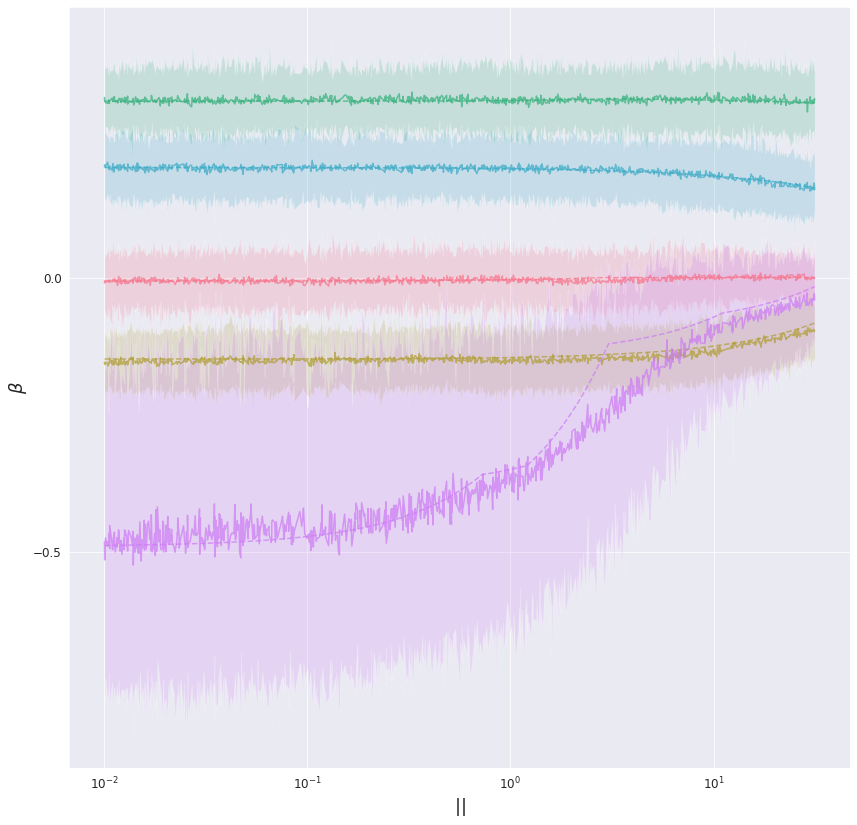

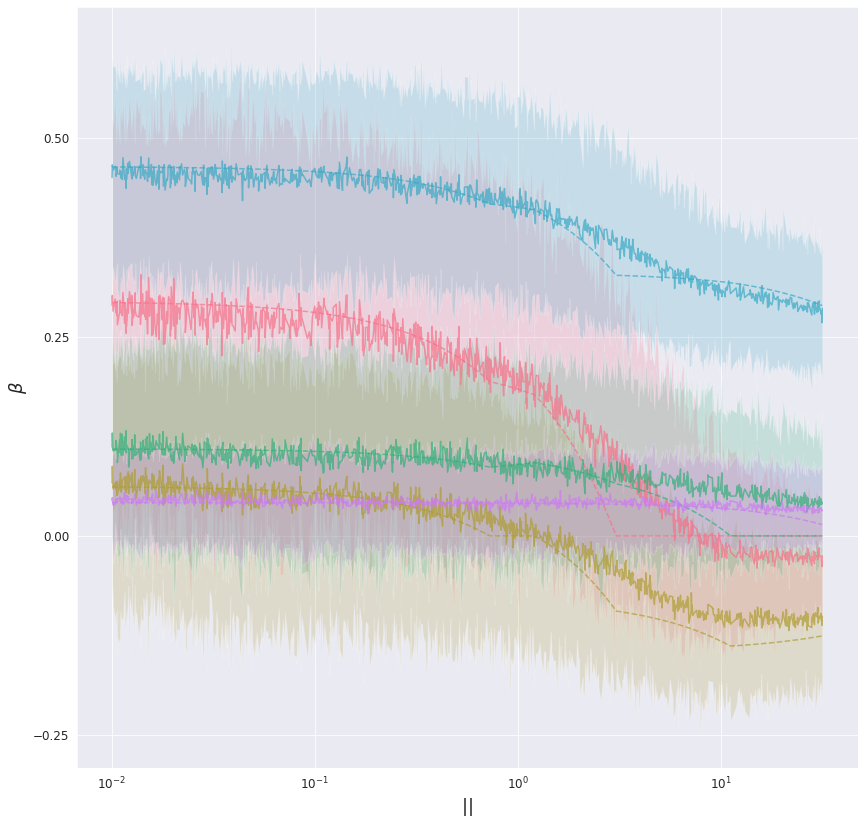

0.84558576 3.9158025
[  17   67  199  444  940 1516 2143 2500 3246 3675 4009 3936 3819 3592
 3247 2951 2758 2598 2591 2591 2510 2525 2520 2536 2550 2481 2365 2336
 2271 2179 2129 2073 2041 1938 1874 1843 1702 1752 1576 1456 1379 1232
 1162 1044  950  851  748  659  565  447]


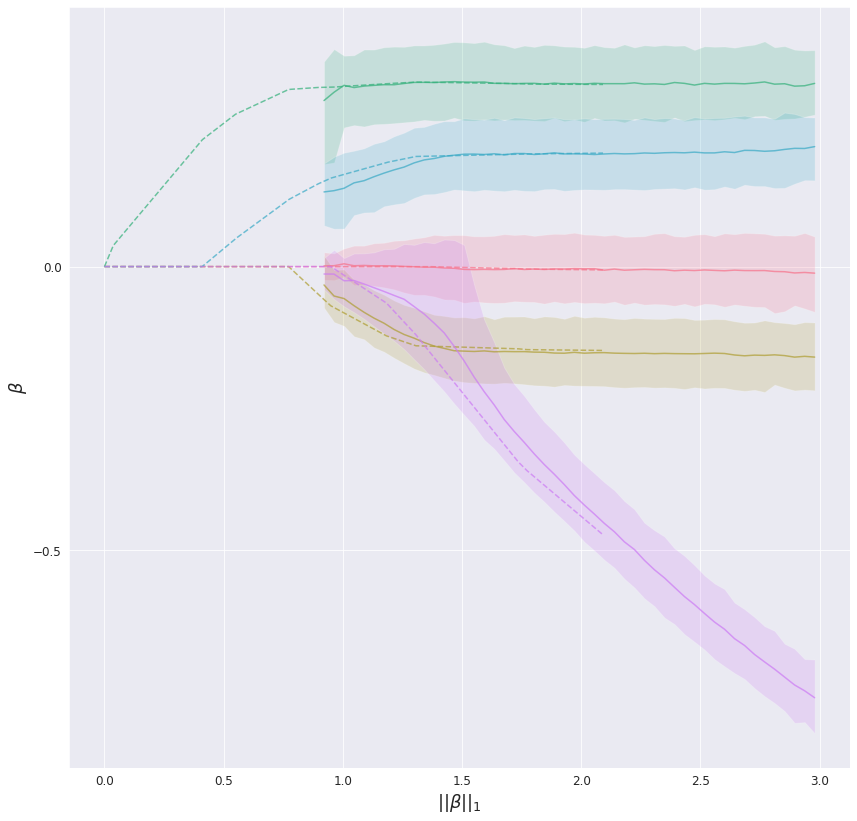

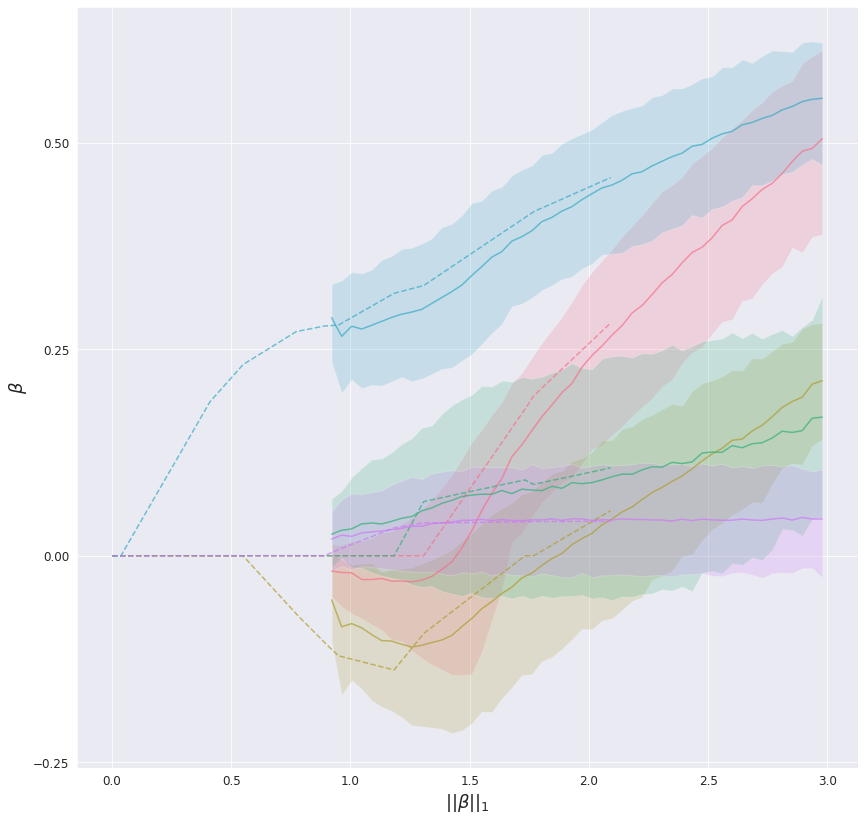

/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils.py:437: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_norm = np.array([all_samples[digitized == i][:min_n_per_bin] for i in range(1, len(bins))])


In [14]:
bins, samples_flow, l_flow, means_flow, r_flow = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

100%|██████████| 1000/1000 [00:01<00:00, 950.46it/s]


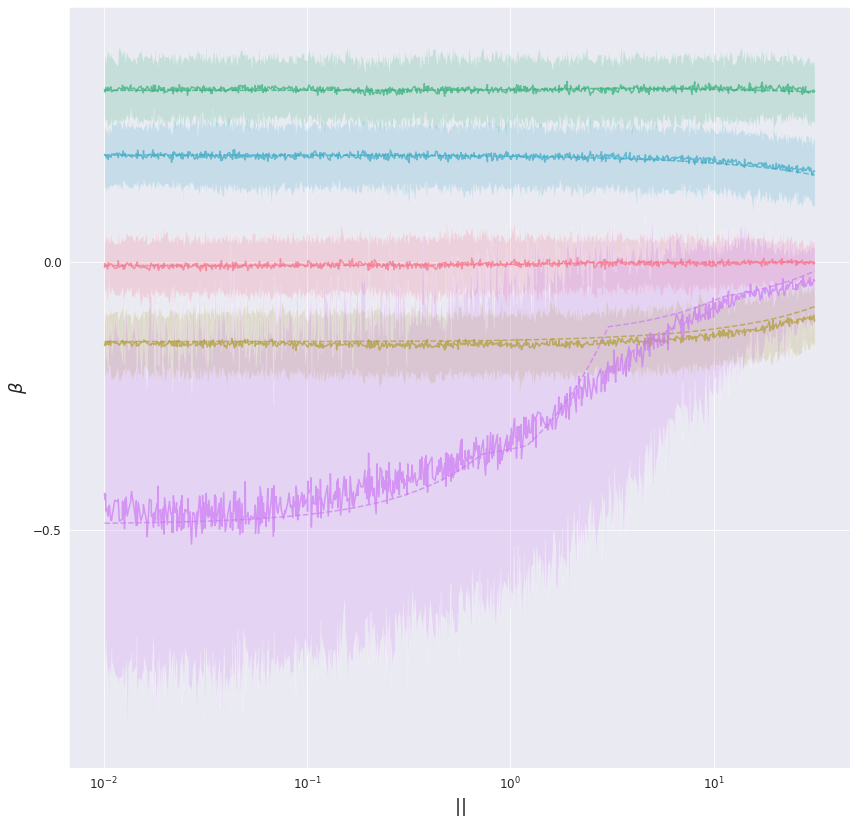

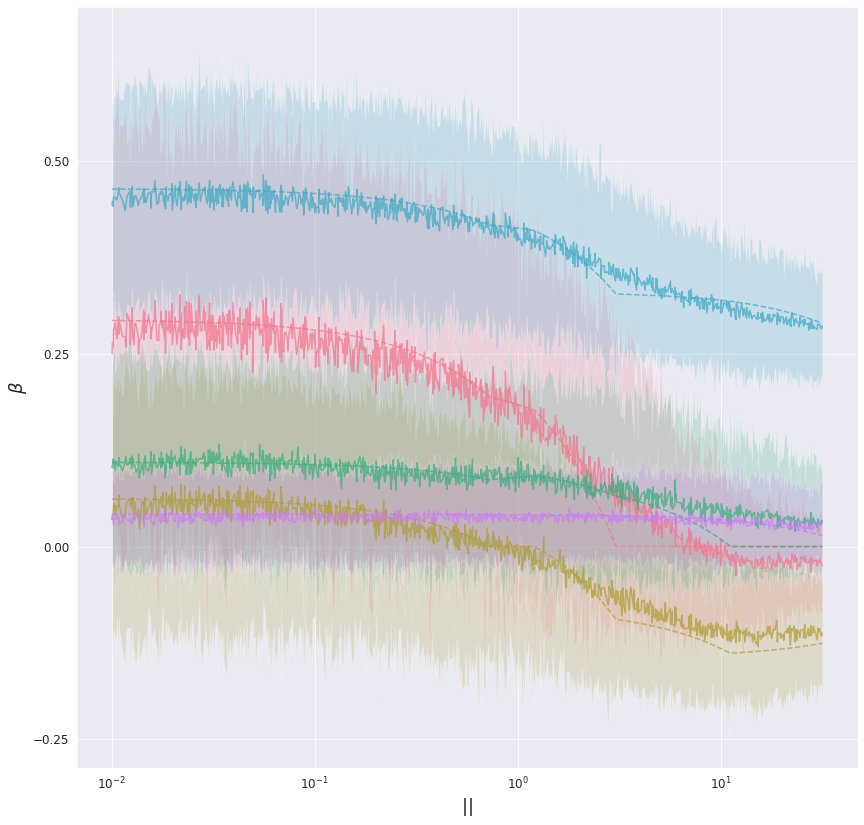

0.8750736 4.683648
[   7   55  169  392  862 1409 2260 2921 3501 4131 4212 4181 4143 3738
 3376 3145 2766 2712 2760 2528 2495 2484 2428 2451 2349 2275 2335 2291
 2200 2178 2100 2086 1983 1938 1788 1755 1680 1564 1487 1348 1260 1088
  952  910  789  725  606  524  416  375]


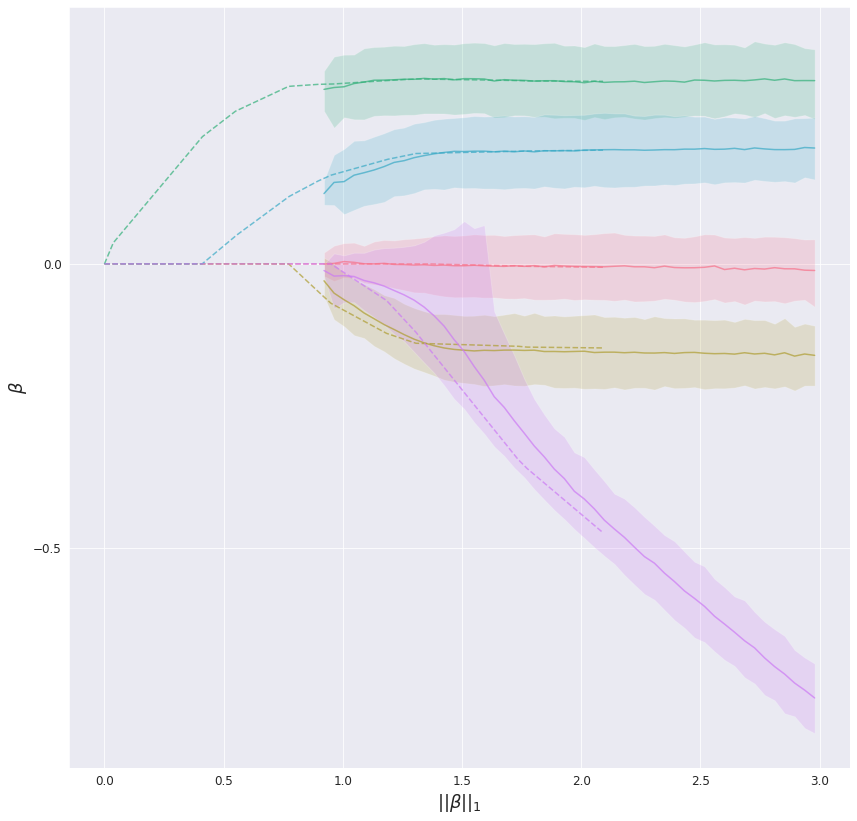

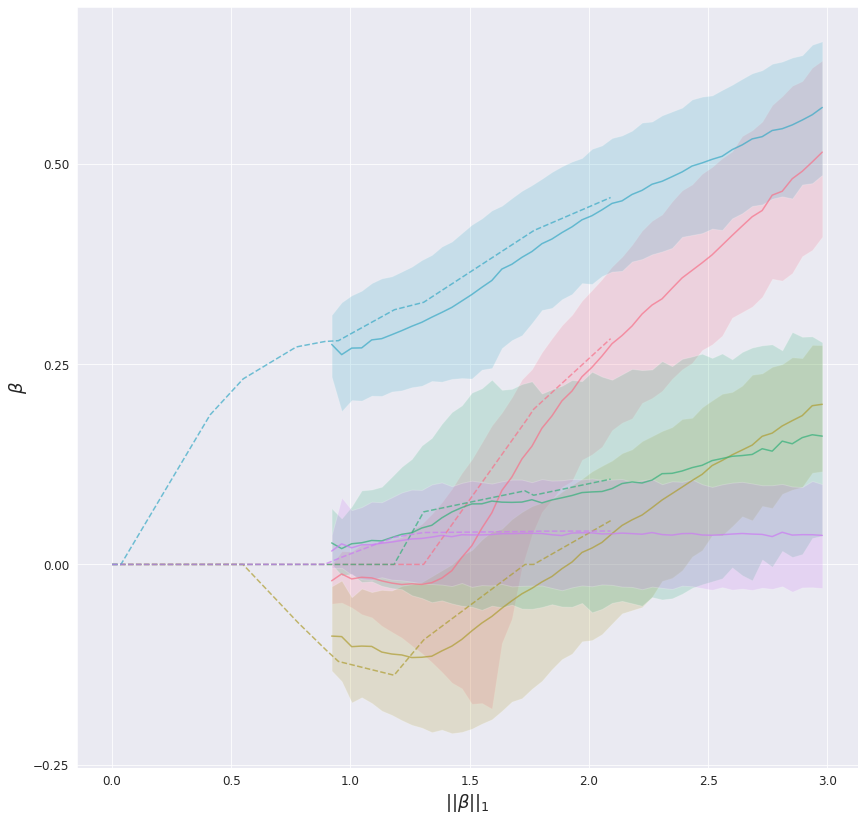

/home/negri0001/Documents/Marcello/cond_flows/manifold_flow/utils.py:437: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples_norm = np.array([all_samples[digitized == i][:min_n_per_bin] for i in range(1, len(bins))])


In [10]:
bins, samples_flow, l_flow, means_flow, r_flow = utils.plot_betas_lambda(samples_sorted, lambda_sorted,  X_np, y_np, sigma=params_flow['sigma'], norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Sample from Bayes Lasso

In [16]:
data_df = pd.DataFrame(np.c_[y_np,X_np], 
                       columns = ['target','0','1','2','3','4','5','6','7','8','9'])

Training loss at step 0: 6046.3 and 592.6 * (T = 10.000)
Training loss at step 1: 5570.4 and 545.3 * (T = 10.000)
Training loss at step 2: 4857.2 and 474.6 * (T = 10.000)
Training loss at step 3: 4593.4 and 448.7 * (T = 10.000)
Training loss at step 4: 4163.4 and 406.2 * (T = 10.000)
Training loss at step 5: 3656.8 and 356.3 * (T = 10.000)
Training loss at step 6: 3352.9 and 326.4 * (T = 10.000)
Training loss at step 7: 2899.0 and 281.8 * (T = 10.000)
Training loss at step 8: 2498.9 and 242.8 * (T = 10.000)
Training loss at step 9: 2300.4 and 223.9 * (T = 10.000)
Training loss at step 10: 2105.1 and 205.1 * (T = 10.000)
Training loss at step 11: 1858.4 and 181.5 * (T = 10.000)
Training loss at step 12: 1676.5 and 164.4 * (T = 10.000)
Training loss at step 13: 1509.8 and 149.0 * (T = 10.000)
Training loss at step 14: 1368.5 and 136.1 * (T = 10.000)
Training loss at step 15: 1172.7 and 118.6 * (T = 10.000)
Training loss at step 16: 1092.5 and 112.1 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:11<00:00, 84.05it/s]


Training loss at step 0: 6699.5 and 658.0 * (T = 10.000)
Training loss at step 1: 5932.9 and 581.8 * (T = 10.000)
Training loss at step 2: 5368.3 and 525.7 * (T = 10.000)
Training loss at step 3: 4937.5 and 483.3 * (T = 10.000)
Training loss at step 4: 4364.3 and 426.5 * (T = 10.000)
Training loss at step 5: 3989.8 and 389.7 * (T = 10.000)
Training loss at step 6: 3588.6 and 350.2 * (T = 10.000)
Training loss at step 7: 3106.0 and 302.7 * (T = 10.000)
Training loss at step 8: 2875.9 and 280.7 * (T = 10.000)
Training loss at step 9: 2662.2 and 260.3 * (T = 10.000)
Training loss at step 10: 2264.8 and 221.8 * (T = 10.000)
Training loss at step 11: 2059.7 and 202.4 * (T = 10.000)
Training loss at step 12: 1878.4 and 185.0 * (T = 10.000)
Training loss at step 13: 1666.9 and 165.4 * (T = 10.000)
Training loss at step 14: 1517.0 and 151.7 * (T = 10.000)
Training loss at step 15: 1373.4 and 138.4 * (T = 10.000)
Training loss at step 16: 1212.1 and 124.3 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:12<00:00, 82.93it/s]


Training loss at step 0: 7229.1 and 711.3 * (T = 10.000)
Training loss at step 1: 6787.1 and 667.6 * (T = 10.000)
Training loss at step 2: 6251.5 and 614.3 * (T = 10.000)
Training loss at step 3: 5685.0 and 558.2 * (T = 10.000)
Training loss at step 4: 5018.5 and 492.1 * (T = 10.000)
Training loss at step 5: 4456.3 and 436.4 * (T = 10.000)
Training loss at step 6: 4273.3 and 418.8 * (T = 10.000)
Training loss at step 7: 3772.3 and 369.5 * (T = 10.000)
Training loss at step 8: 3639.7 and 357.0 * (T = 10.000)
Training loss at step 9: 3217.4 and 315.8 * (T = 10.000)
Training loss at step 10: 2837.3 and 279.0 * (T = 10.000)
Training loss at step 11: 2613.0 and 257.5 * (T = 10.000)
Training loss at step 12: 2380.5 and 235.4 * (T = 10.000)
Training loss at step 13: 2147.3 and 213.2 * (T = 10.000)
Training loss at step 14: 2032.6 and 202.9 * (T = 10.000)
Training loss at step 15: 1911.2 and 192.0 * (T = 10.000)
Training loss at step 16: 1726.7 and 174.9 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:11<00:00, 84.44it/s]


Training loss at step 0: 7793.9 and 767.2 * (T = 10.000)
Training loss at step 1: 7124.7 and 700.8 * (T = 10.000)
Training loss at step 2: 6853.8 and 674.2 * (T = 10.000)
Training loss at step 3: 6018.5 and 591.2 * (T = 10.000)
Training loss at step 4: 5347.3 and 524.6 * (T = 10.000)
Training loss at step 5: 4637.4 and 454.3 * (T = 10.000)
Training loss at step 6: 4304.6 and 421.9 * (T = 10.000)
Training loss at step 7: 3738.0 and 366.1 * (T = 10.000)
Training loss at step 8: 3345.5 and 327.8 * (T = 10.000)
Training loss at step 9: 2841.8 and 278.3 * (T = 10.000)
Training loss at step 10: 2360.6 and 231.9 * (T = 10.000)
Training loss at step 11: 2148.6 and 211.5 * (T = 10.000)
Training loss at step 12: 1874.9 and 185.7 * (T = 10.000)
Training loss at step 13: 1645.0 and 164.6 * (T = 10.000)
Training loss at step 14: 1432.2 and 144.1 * (T = 10.000)
Training loss at step 15: 1238.9 and 127.1 * (T = 10.000)
Training loss at step 16: 1127.7 and 117.7 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:13<00:00, 76.74it/s]


Training loss at step 0: 8398.3 and 827.8 * (T = 10.000)
Training loss at step 1: 7914.2 and 779.9 * (T = 10.000)
Training loss at step 2: 7234.8 and 712.4 * (T = 10.000)
Training loss at step 3: 6263.7 and 615.9 * (T = 10.000)
Training loss at step 4: 5674.5 and 557.6 * (T = 10.000)
Training loss at step 5: 5064.8 and 497.3 * (T = 10.000)
Training loss at step 6: 4292.5 and 420.8 * (T = 10.000)
Training loss at step 7: 4143.7 and 406.8 * (T = 10.000)
Training loss at step 8: 3569.4 and 350.5 * (T = 10.000)
Training loss at step 9: 3004.9 and 295.1 * (T = 10.000)
Training loss at step 10: 2710.6 and 266.6 * (T = 10.000)
Training loss at step 11: 2341.7 and 231.5 * (T = 10.000)
Training loss at step 12: 2070.7 and 205.7 * (T = 10.000)
Training loss at step 13: 1811.3 and 180.8 * (T = 10.000)
Training loss at step 14: 1557.3 and 157.0 * (T = 10.000)
Training loss at step 15: 1448.7 and 147.9 * (T = 10.000)
Training loss at step 16: 1309.1 and 135.7 * (T = 10.000)
Training loss at step 17

100%|██████████| 1000/1000 [00:13<00:00, 73.72it/s]


In [7]:
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('bayes_lasso.R')# Loading the function we have defined in R.
bayes_function = robjects.globalenv['bayes_function']# Reading and processing data
bayes_function_opt_alpha  = (robjects.globalenv)['bayes_function_opt_alpha']# Reading and processing data

100%|██████████| 1000/1000 [00:12<00:00, 81.62it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1451.71it/s]


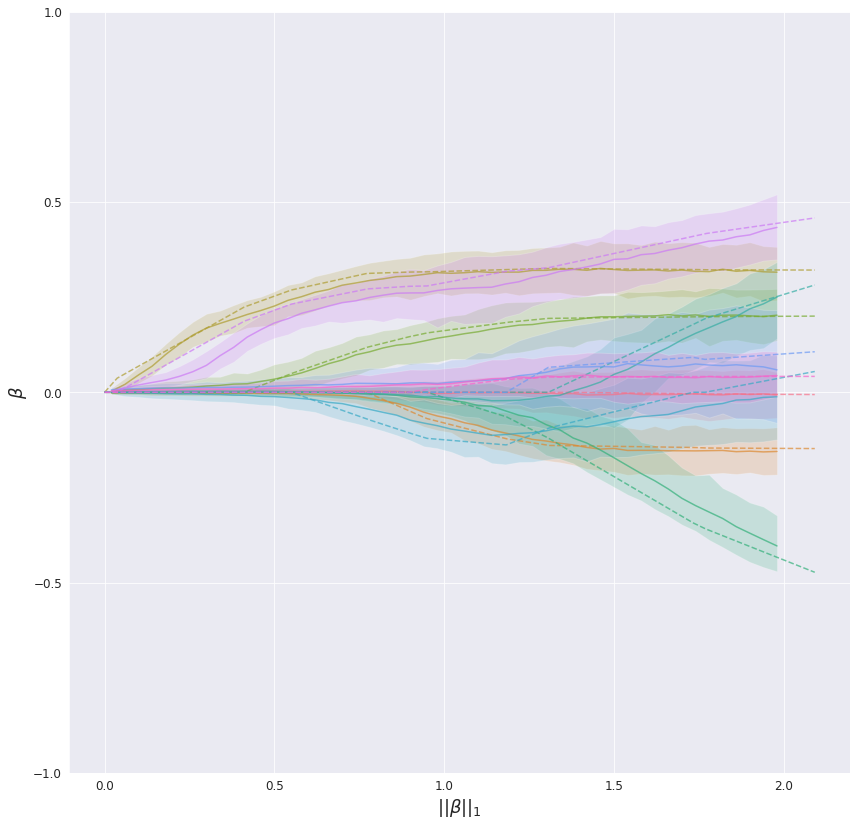

100%|██████████| 1000/1000 [00:00<00:00, 1431.73it/s]


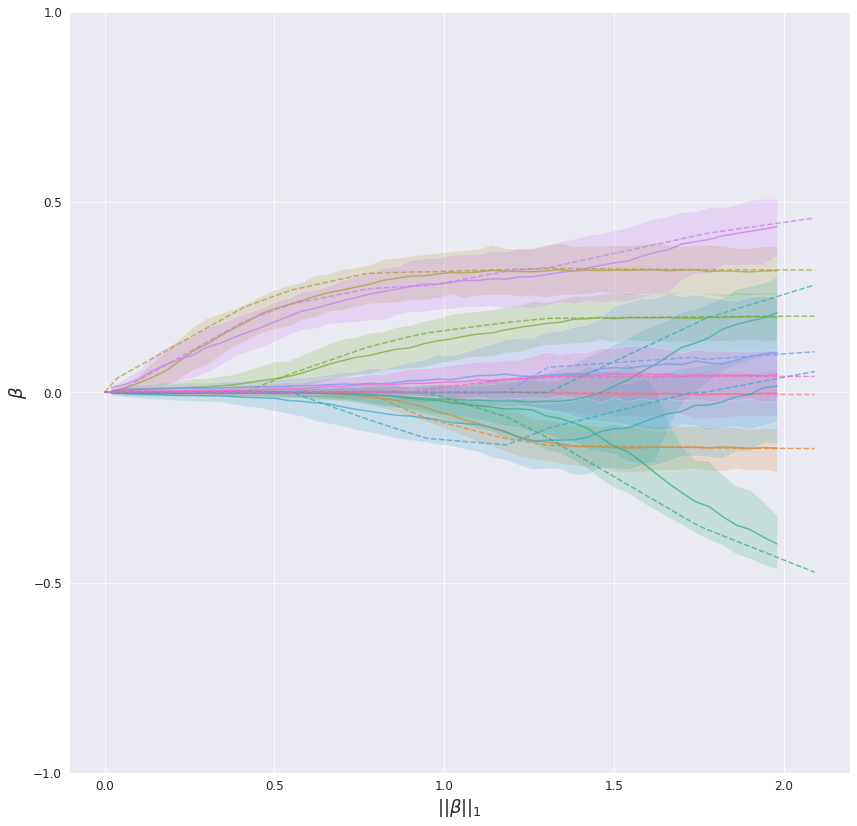

100%|██████████| 1000/1000 [00:00<00:00, 1364.69it/s]


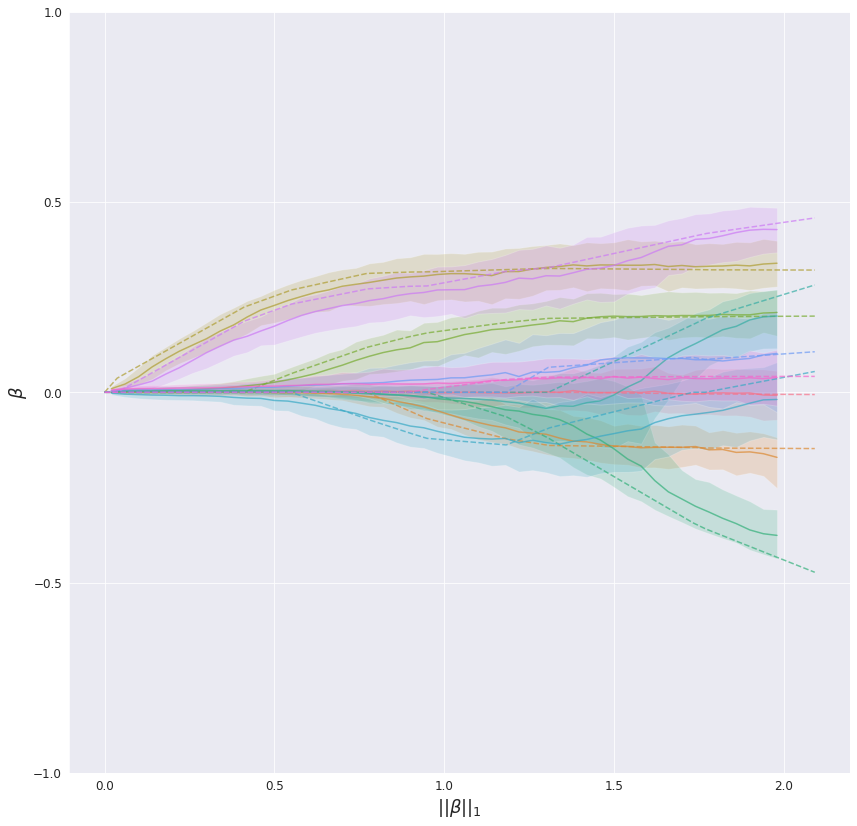

100%|██████████| 1000/1000 [00:00<00:00, 1396.30it/s]


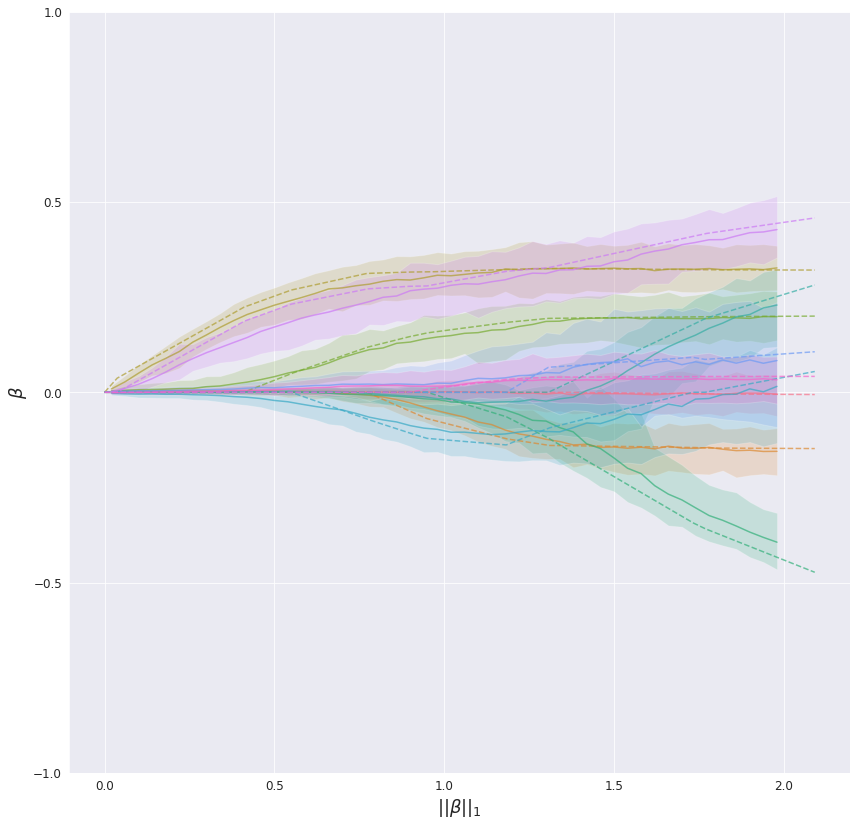

100%|██████████| 1000/1000 [00:00<00:00, 1291.95it/s]


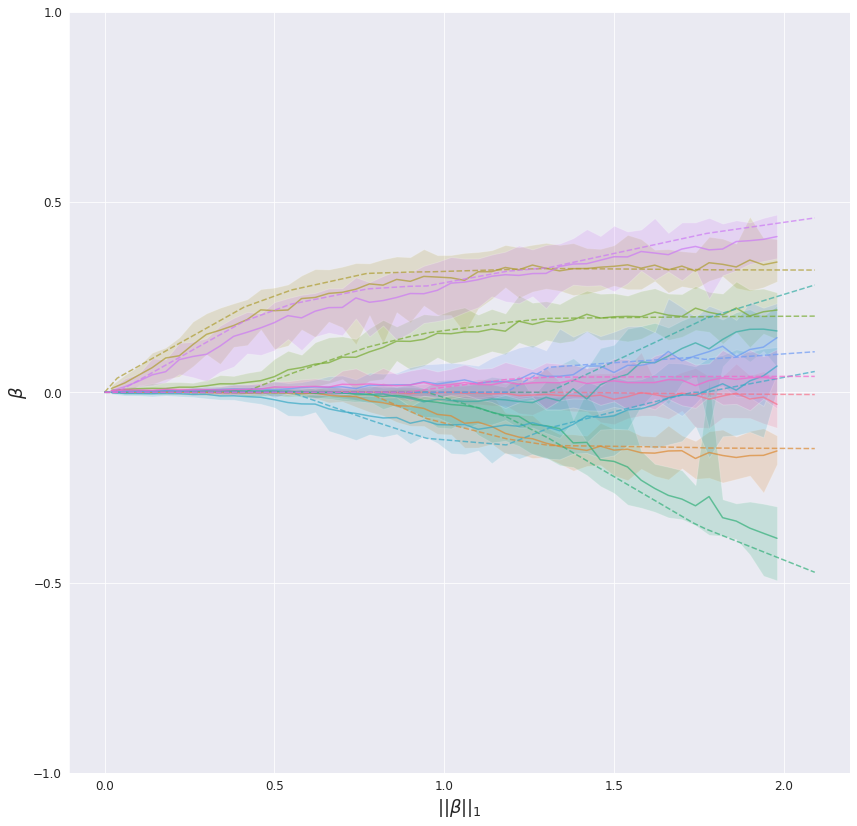

In [21]:
alphas_lasso = np.logspace(-1, 3, 100)

In [27]:
alphas_lasso = np.logspace(-1, 3, 100)
coefs, ci_l, ci_r, all_samples = [], [], [], []
conf = 0.95
for alpha in alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    all_samples.append(bayes_samples)
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)

all_samples_raveled = np.concatenate(all_samples, 0)
all_samples = np.array(all_samples)
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)

(50, 50, 10)

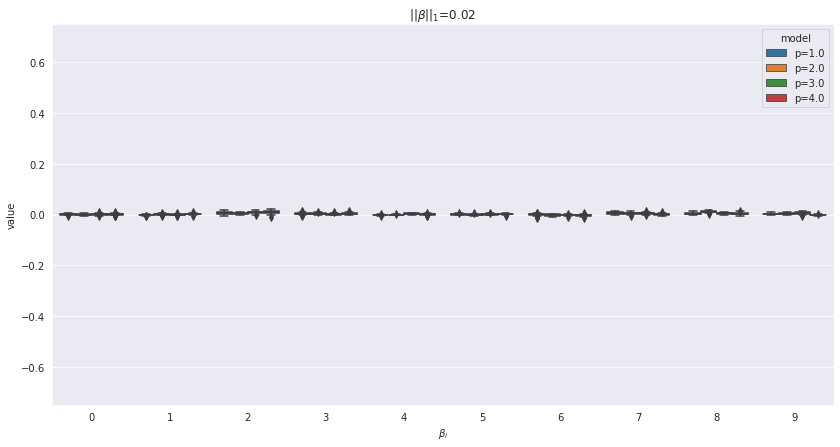

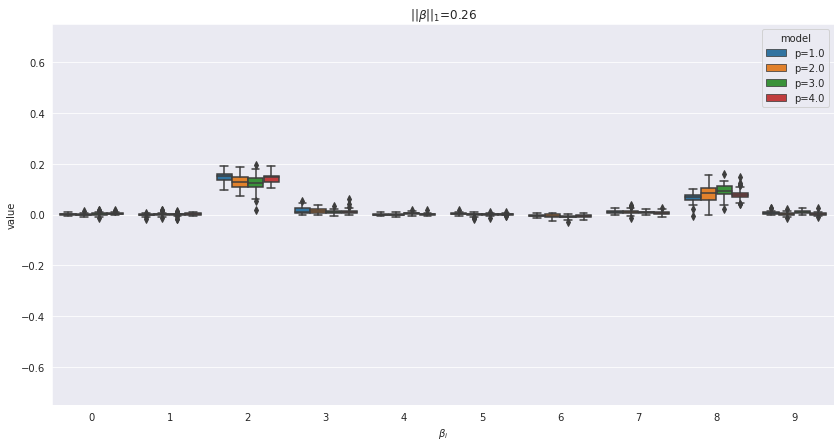

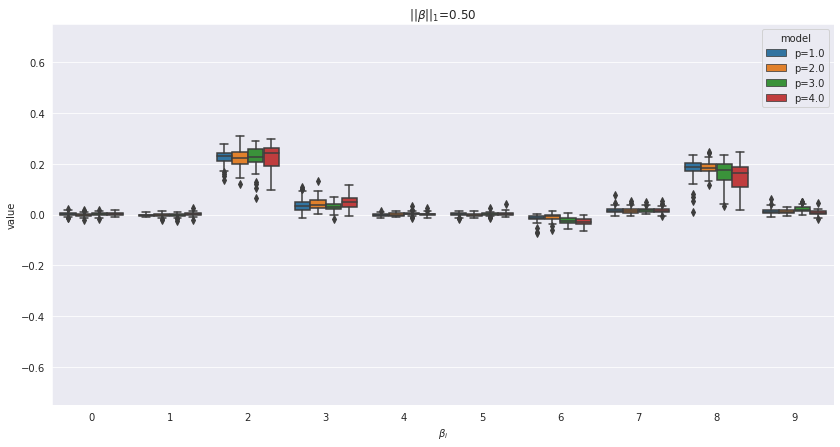

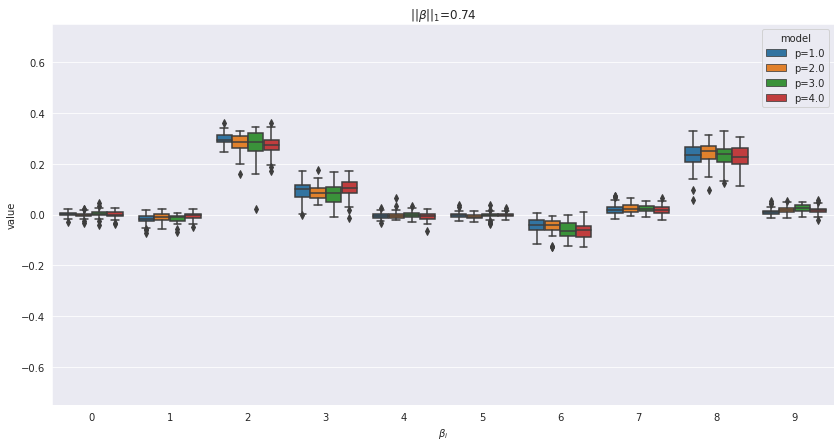

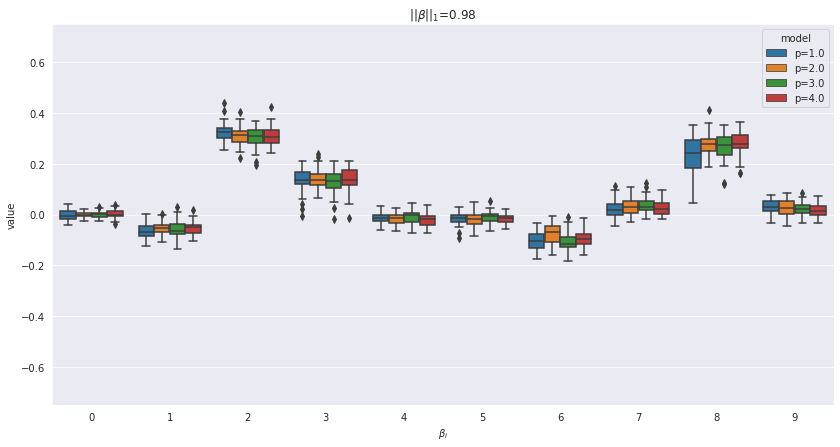

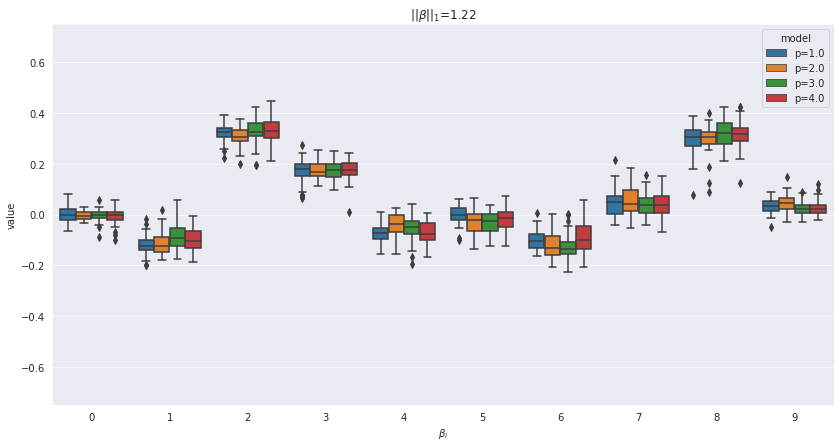

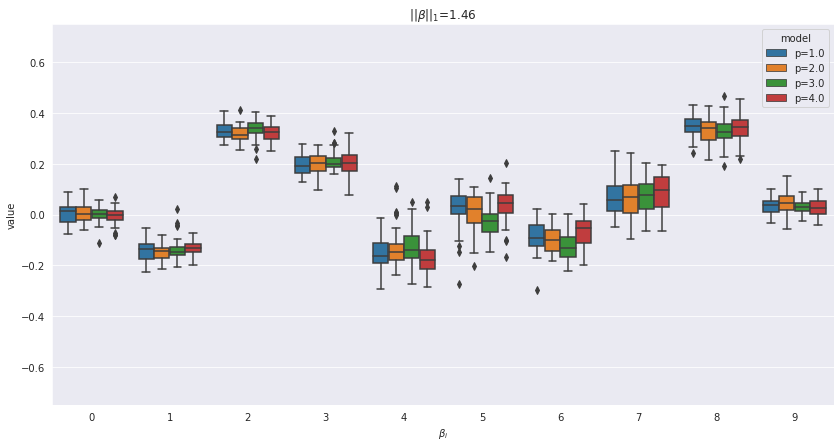

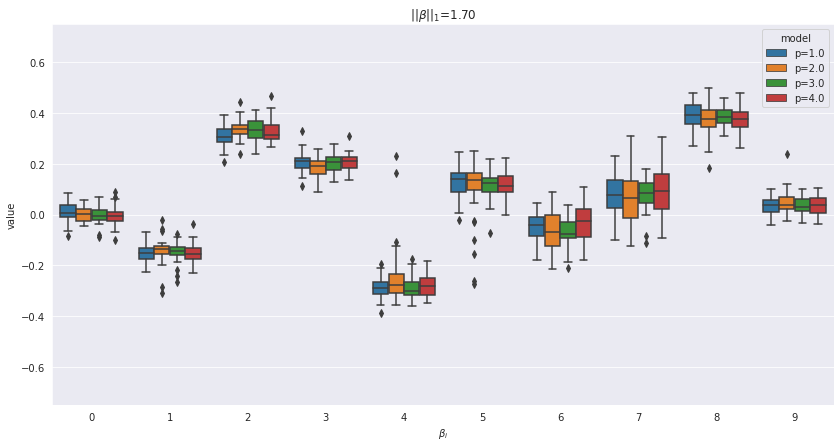

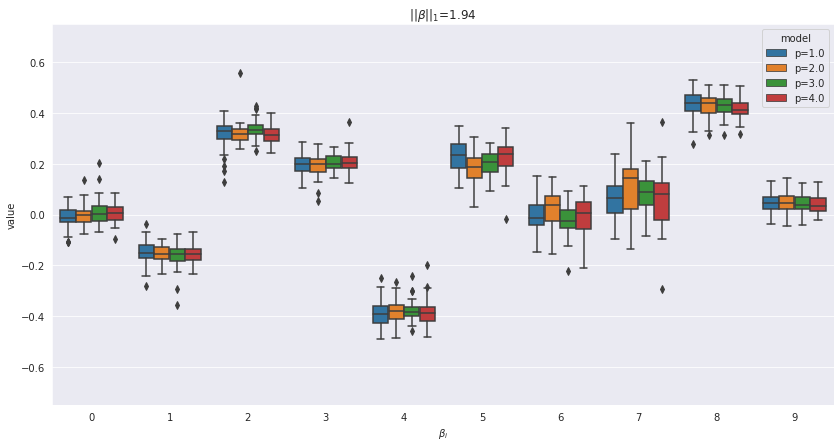

In [28]:
bins, samples_bayes, l_bayes, means_bayes, r_bayes = utils.plot_betas_lambda(all_samples, alphas_lasso,  X_np, y_np, norm=params_flow['q'], a=0.95, folder_name=dir_name, n_plots=2)

### Bayesian linear regression comparison 
- Bayesian linear regression
- Normalizing Flow with Laplace prior and conditioned on $\lambda$
- Normalizing Flow defined on L1 manifold and conditioned on $||\beta||_1=t$

In [28]:
# sample from NF with Laplace prior
flow = utils.build_cond_flow(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow.load_state_dict(torch.load("./models/flow_T_1"))
alphas_lasso = np.linspace(-1, 3, 10)
alphas_lasso_torch = torch.from_numpy(alphas_lasso).to(device).to(torch.float32).view(-1,1)
flow_samples, log_probs_samples = flow.sample_and_log_prob(1000, context=alphas_lasso_torch)
flow_samples_np = flow_samples.detach().cpu().numpy()
del flow_samples, log_probs_samples, flow
torch.cuda.empty_cache()
norms_flow = np.abs(flow_samples_np).sum(-1).mean(-1)

In [29]:
# sample from Bayesian Lasso 
coefs, ci_l, ci_r, norms_bayes_lasso = [], [], [], []
conf = 0.95
all_samples_bayes = {}
for alpha in 10**alphas_lasso:
    print("=+"*100)
    print('alpha: ', alpha)
    df_result = bayes_function(data_df, alpha=1/alpha, chain=1)
    bayes_samples = np.array(pd.DataFrame(df_result)).T
    bayes_samples = bayes_samples[:,1:-1]
    l_quant = np.quantile(bayes_samples, 1 - conf, axis=0)
    sample_mean = np.mean(bayes_samples, axis=0)
    r_quant = np.quantile(bayes_samples, conf, axis=0)
    sample_norm = np.abs(bayes_samples).sum(-1).mean()
    all_samples_bayes[f"{sample_norm:.4f}"] = bayes_samples
    norms_bayes_lasso.append(sample_norm)
    coefs.append(sample_mean)
    ci_l.append(l_quant)
    ci_r.append(r_quant)
    
coefs = np.array(coefs)
ci_l = np.array(ci_l)
ci_r = np.array(ci_r)
norms_bayes_lasso = np.array(norms_bayes_lasso)

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
alpha:  0.1

SAMPLING FOR MODEL 'continuous' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 2.4e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.24 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800

In [30]:
# sample from NF on manifold
flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_manifold = 0.5*(norms_bayes_lasso + norms_flow)
norms_flow_torch = torch.from_numpy(norms_flow_manifold).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(10)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(100, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 10/10 [00:00<00:00, 16.21it/s]


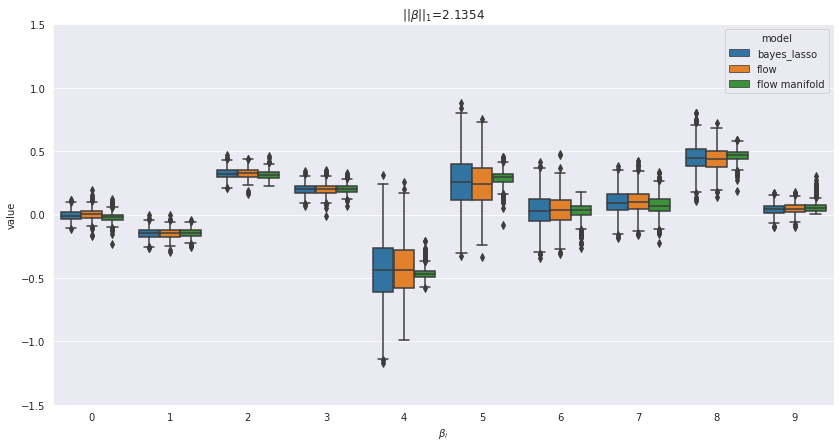

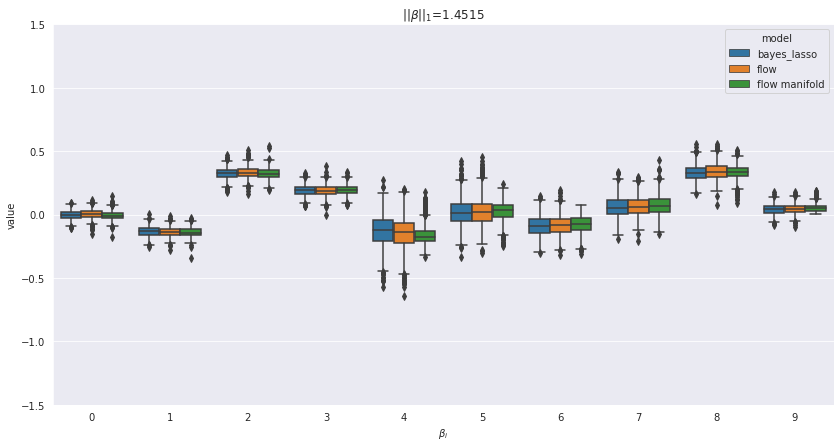

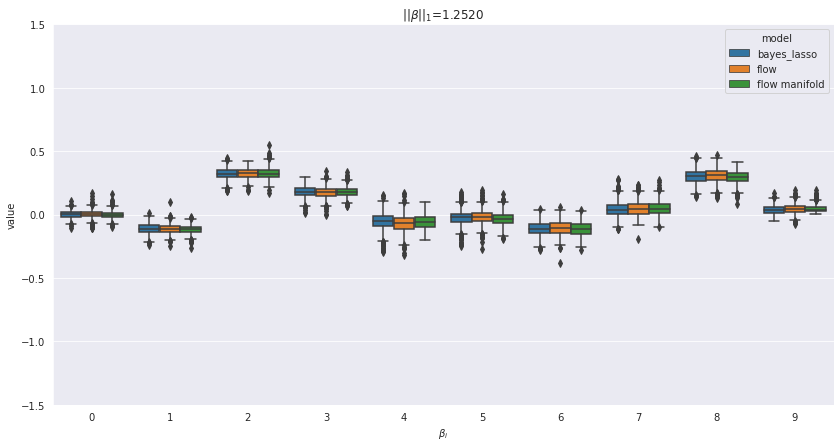

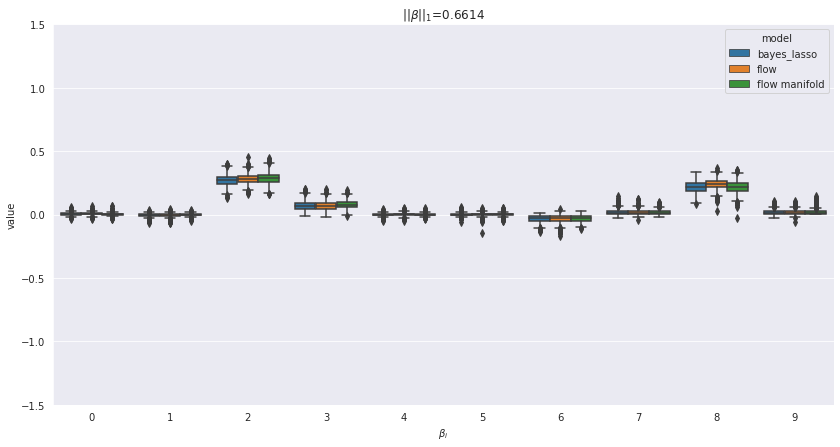

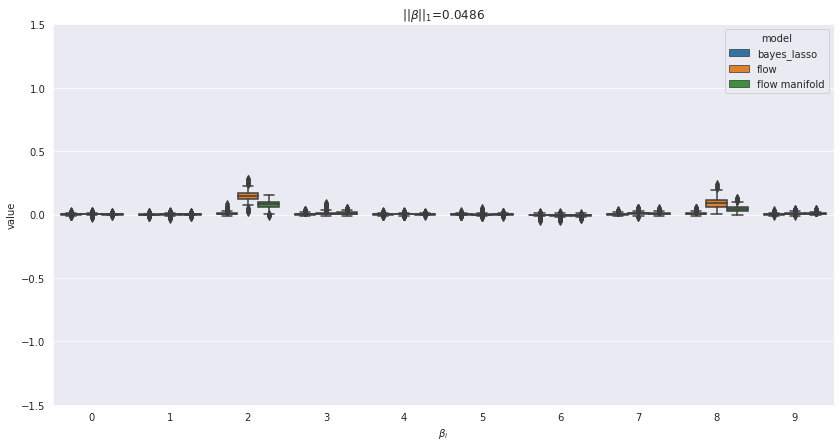

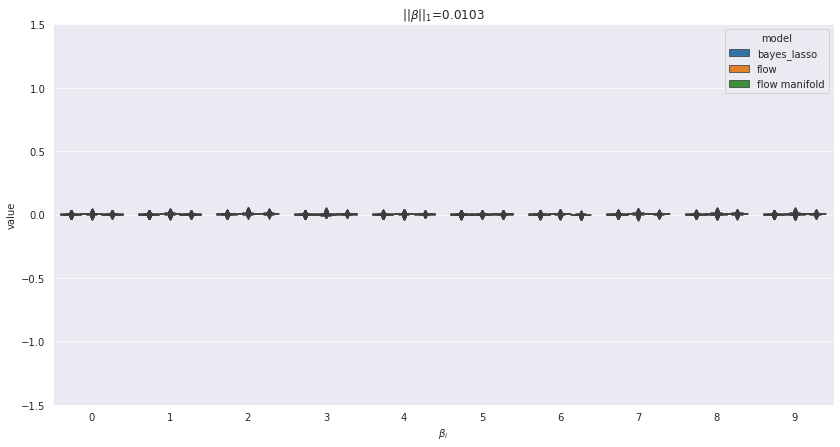

In [31]:
# plot comparison
for i, key_norm in enumerate(all_samples_bayes.keys()):
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(all_samples_bayes[key_norm]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(flow_samples_np[i]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={}".format(key_norm))
    plt.ylim(-1.5,1.5)
    plt.savefig(f"./plots/box_plot_norm_lambda_{key_norm}.pdf")
    plt.show()

In [19]:
min_samples = min(samples_flow.shape[1], samples_bayes.shape[1])
bins_midpoints = 0.5 * (bins[1:]+bins[:-1])
# sample from NF on manifold
flow_manifold = utils.build_cond_flow_manifold(flow_dim, q=q, n_layers=5, context_features=128, hidden_features=256, device=device)
flow_manifold.load_state_dict(torch.load("./models/flow_manifold_T_1"))
norms_flow_torch = torch.from_numpy(bins_midpoints).to(device).to(torch.float32).view(-1,1)
manifold_samples = []
for i in tqdm.tqdm(range(min_samples//20)):
    flow_manifold_samples, log_probs_samples = flow_manifold.sample_and_log_prob(20, context=norms_flow_torch)
    manifold_samples.append(flow_manifold_samples.detach().cpu().numpy())
    del flow_manifold_samples, log_probs_samples
    torch.cuda.empty_cache()
flow_manifold_samples = np.concatenate(manifold_samples, 1)
del flow_manifold
torch.cuda.empty_cache()

100%|██████████| 16/16 [00:01<00:00, 15.90it/s]


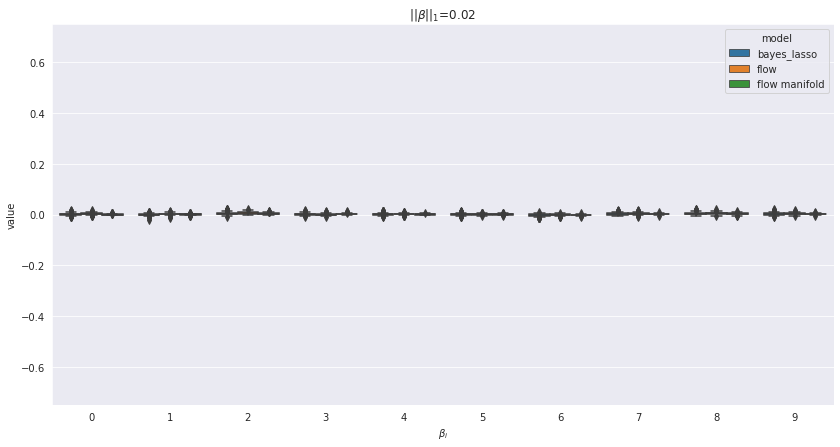

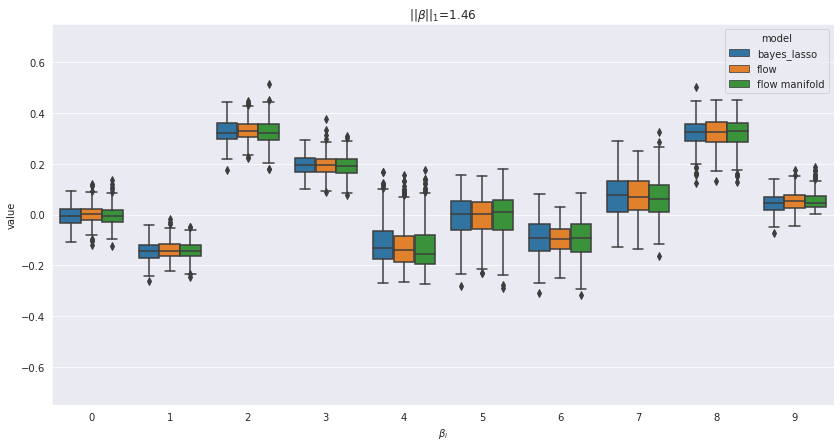

In [27]:
indeces = np.linspace(0,49,50).astype('int')[::6]

# plot comparison
for i in indeces:
    plt.figure(figsize=(14,7))
    bayes_lasso_df = pd.DataFrame(samples_bayes[i,:min_samples]).assign(model="bayes_lasso")
    flow_df = pd.DataFrame(samples_flow[i,:min_samples]).assign(model="flow")
    flow_manifold_df = pd.DataFrame(flow_manifold_samples[i]).assign(model="flow manifold")
    cdf = pd.concat([bayes_lasso_df, flow_df, flow_manifold_df])
    mdf = pd.melt(cdf, id_vars=['model'], var_name=r'$\beta_i$', value_name="value")
    sns.boxplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    # sns.violinplot(x=r'$\beta_i$', y="value", hue="model", data=mdf)
    plt.title(r"$||\beta||_1$={:.2f}".format(bins_midpoints[i]))
    plt.ylim(-0.75,0.75)
    plt.savefig(f"./plots/box_plot_norm_{bins_midpoints[i]:.2f}.pdf")
    plt.show()